# Industrial Energy Consumption Prediction

In [1]:
# --- Block 1: Imports ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import pickle

# Set plotting style for a professional look
sns.set_style("whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- Block 2: Data Loading ---

file_name = 'cleaned_steel_data.csv'
data = pd.read_csv(file_name)

# --- Initial Inspection ---
print("--- Data Info ---")
# .info() gives us column names and data types
data.info()

print("\n--- Data Head (First 5 Rows) ---")
# .head() shows the first few rows of data
print(data.head())

print("\n--- Data Statistical Summary ---")
# .describe() gives a statistical overview
print(data.describe())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34300 entries, 0 to 34299
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             34300 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  34300 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  34300 non-null  float64
 3   CO2(tCO2)                             34300 non-null  float64
 4   Lagging_Current_Power_Factor          34300 non-null  float64
 5   Leading_Current_Power_Factor          34300 non-null  float64
 6   WeekStatus                            34300 non-null  int64  
 7   Day_of_week                           34300 non-null  int64  
 8   Load_Type                             34300 non-null  int64  
 9   month                                 34300 non-null  int64  
 10  day                                   34300 non-null  int64  
 1

Starting EDA... This may take a moment.


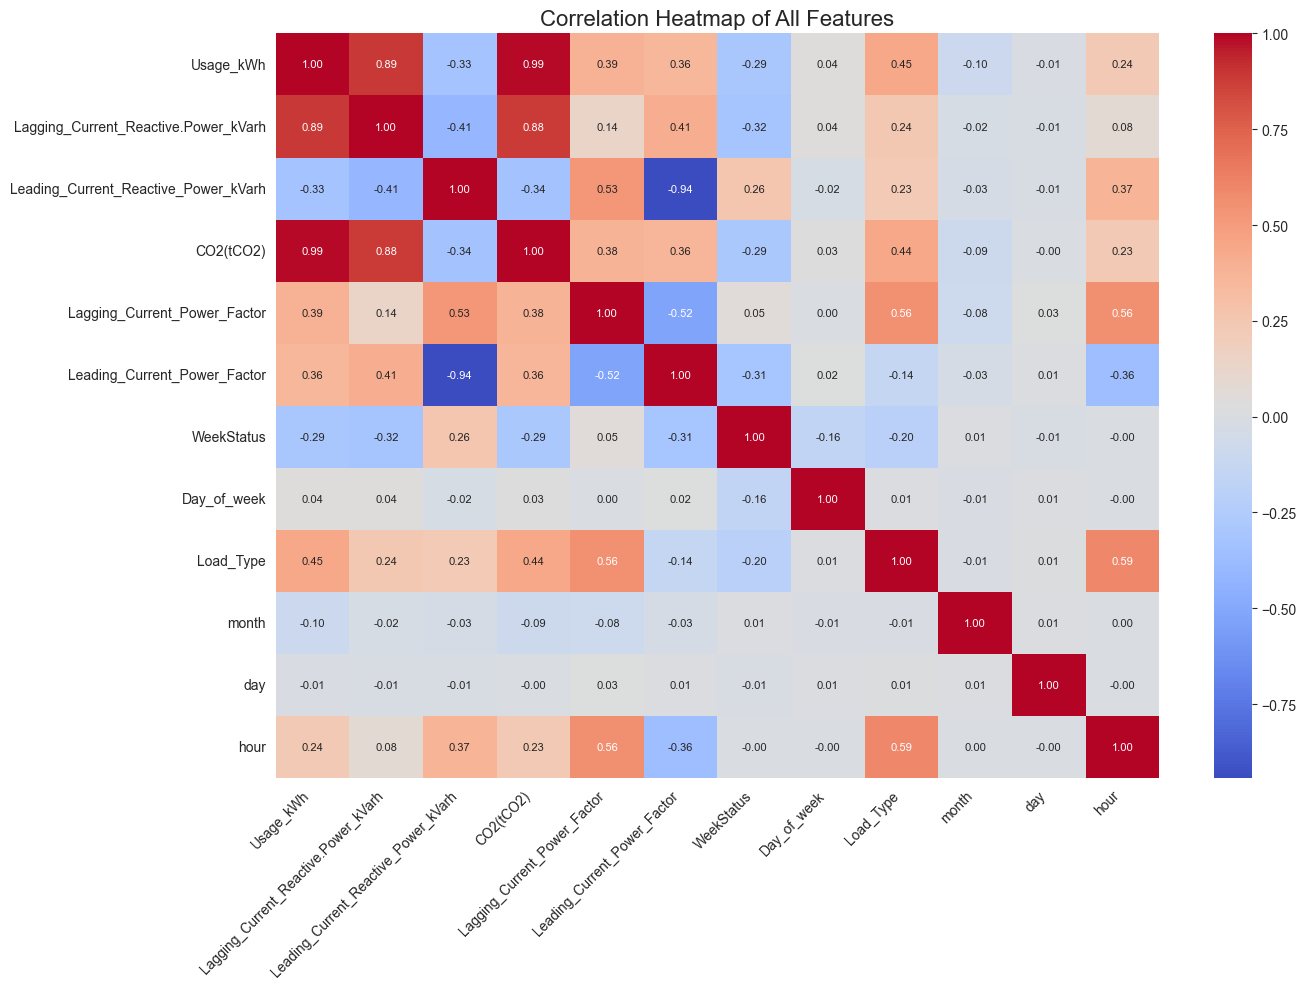

In [3]:
# --- Block 3: Exploratory Data Analysis (EDA) ---

print("Starting EDA... This may take a moment.")

# 1. Correlation Heatmap
# This shows how strongly features are related to each other and the target
plt.figure(figsize=(14, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Correlation Heatmap of All Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



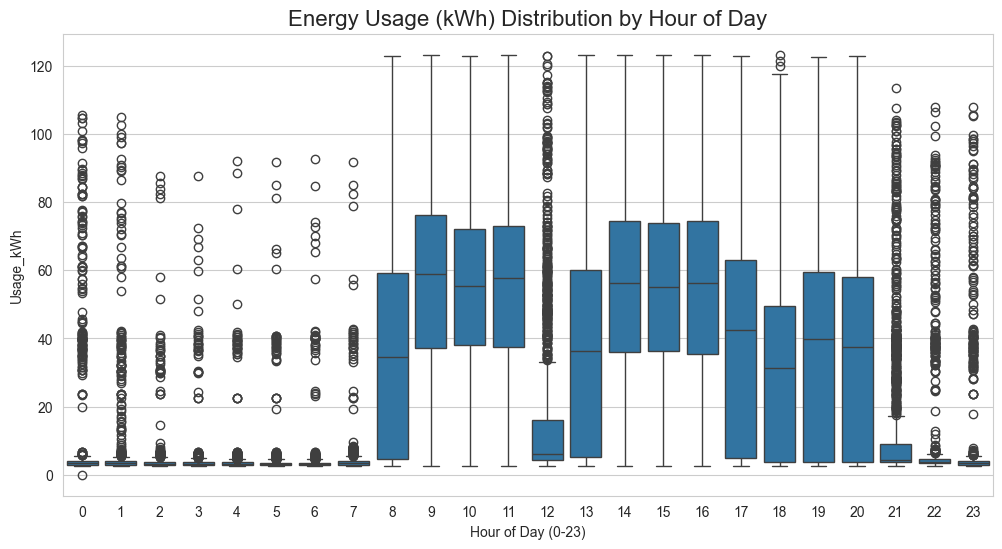

In [4]:
# 2. Boxplot of Usage by Hour
# This shows if energy usage follows a 24-hour cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Usage_kWh', data=data)
plt.title('Energy Usage (kWh) Distribution by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Usage_kWh')
plt.show()



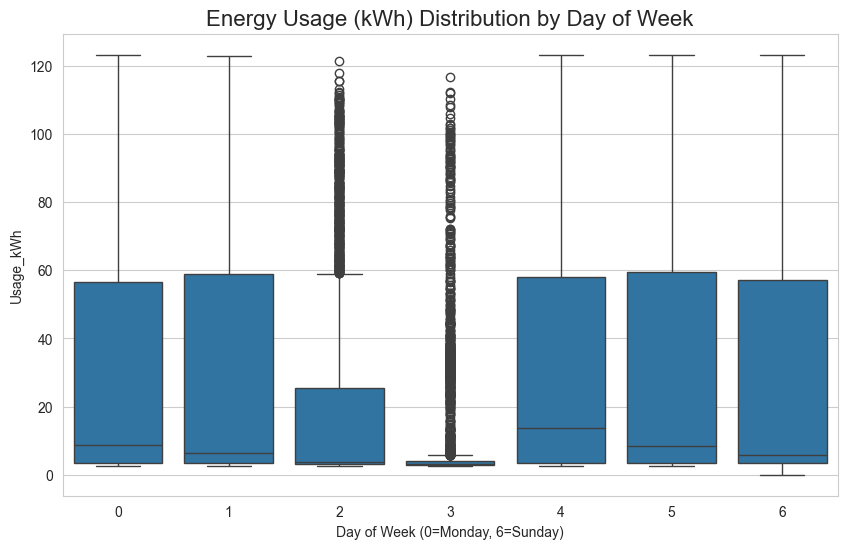

EDA plots complete.


In [5]:
# 3. Boxplot of Usage by Day of Week
# This shows if there is a weekly pattern (e.g., weekends vs. weekdays)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_of_week', y='Usage_kWh', data=data)
plt.title('Energy Usage (kWh) Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Usage_kWh')
plt.show()

print("EDA plots complete.")

In [6]:
# --- Block 4: Feature Engineering ---

print("Starting feature engineering...")

# Create a copy to avoid changing the original data
data_feat = data.sort_values(by=['month', 'day', 'hour']).copy()

# 1. Create a 3-hour rolling average
# This smooths out short-term noise and shows the recent trend
window_size = 3 
data_feat['Usage_kWh_rolling_avg_3hr'] = data_feat['Usage_kWh'].rolling(
    window=window_size, min_periods=1
).mean()

# 2. Create a 1-hour lag feature
# The energy usage *right now* is highly dependent on the usage *last hour*
lag_period = 1
data_feat['Usage_kWh_lag_1hr'] = data_feat['Usage_kWh'].shift(lag_period)

# --- Handle NaNs ---
# The lag and rolling features create NaN values at the very beginning.
# We must drop these rows before training a model.
print(f"Original data rows: {data_feat.shape[0]}")
data_feat = data_feat.dropna()
print(f"Rows after dropping NaNs: {data_feat.shape[0]}")

print("\n--- Data Head with New Features ---")
print(data_feat.head())

# --- Save this new data ---
# This file will be used by your Streamlit dashboard
output_csv_name = 'steel_data_with_features.csv'
data_feat.to_csv(output_csv_name, index=False)
print(f"\nFeature-engineered data saved to '{output_csv_name}'")

Starting feature engineering...
Original data rows: 34300
Rows after dropping NaNs: 34299

--- Data Head with New Features ---
    Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
1        4.00                                  4.46   
2        3.24                                  3.28   
95       3.42                                  3.46   
3        3.31                                  3.56   
4        3.82                                  4.50   

    Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
1                                    0.0        0.0   
2                                    0.0        0.0   
95                                   0.0        0.0   
3                                    0.0        0.0   
4                                    0.0        0.0   

    Lagging_Current_Power_Factor  Leading_Current_Power_Factor  WeekStatus  \
1                          66.77                         100.0           0   
2                          70.28                       

In [7]:
# Define the target variable
target = 'Usage_kWh'

# Define the features (all columns EXCEPT the target)
features = [col for col in data_feat.columns if col != target]

X = data_feat[features]
y = data_feat[target]


In [8]:
print(f"Features being used: {features}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Features being used: ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'WeekStatus', 'Day_of_week', 'Load_Type', 'month', 'day', 'hour', 'Usage_kWh_rolling_avg_3hr', 'Usage_kWh_lag_1hr']

Training set size: 27439 samples
Test set size: 6860 samples


In [10]:
# --- Block 6: Model Training (XGBoost) ---

print("Initializing and training XGBoost model...")

# Initialize the XGBoost Regressor
# NOTE: early_stopping_rounds has been moved into the constructor
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',    # Tell XGBoost this is a regression problem
    n_estimators=1000,               # Number of trees to build
    learning_rate=0.05,              # How quickly the model learns
    max_depth=6,                     # Max depth of each tree
    subsample=0.8,                   # Fraction of data to use for each tree
    colsample_bytree=0.8,            # Fraction of features to use for each tree
    random_state=42,
    n_jobs=-1,                       # Use all available CPU cores
    early_stopping_rounds=50         # MOVED HERE! Stop if performance doesn't improve
)

# Train the model on the training data
# We add an evaluation set to monitor for overfitting
# The model will use the last item in eval_set (X_test, y_test) for early stopping
print("Training model with early stopping...")
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)             # Print updates every 100 rounds

print("--- Model training complete ---")

Initializing and training XGBoost model...
Training model with early stopping...
[0]	validation_0-rmse:30.50315	validation_1-rmse:30.59763
[100]	validation_0-rmse:1.76529	validation_1-rmse:1.91496
[200]	validation_0-rmse:1.21827	validation_1-rmse:1.48063
[300]	validation_0-rmse:0.94904	validation_1-rmse:1.27753
[400]	validation_0-rmse:0.78615	validation_1-rmse:1.16248
[500]	validation_0-rmse:0.66965	validation_1-rmse:1.08540
[600]	validation_0-rmse:0.58885	validation_1-rmse:1.03481
[700]	validation_0-rmse:0.52435	validation_1-rmse:0.99586
[800]	validation_0-rmse:0.47243	validation_1-rmse:0.97026
[900]	validation_0-rmse:0.42995	validation_1-rmse:0.94769
[999]	validation_0-rmse:0.39494	validation_1-rmse:0.93228
--- Model training complete ---


In [11]:
# --- Block 7: Model Evaluation ---

# Make predictions on the test set
y_pred = xgb_reg.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_absolute_error(y_test, y_pred)) # Root Mean Squared Error

print(f"\n--- XGBoost Model Evaluation ---")
print(f'R-squared (R2): {r2:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')




--- XGBoost Model Evaluation ---
R-squared (R2): 0.9992
Mean Absolute Error (MAE): 0.4495
Root Mean Squared Error (RMSE): 0.6704


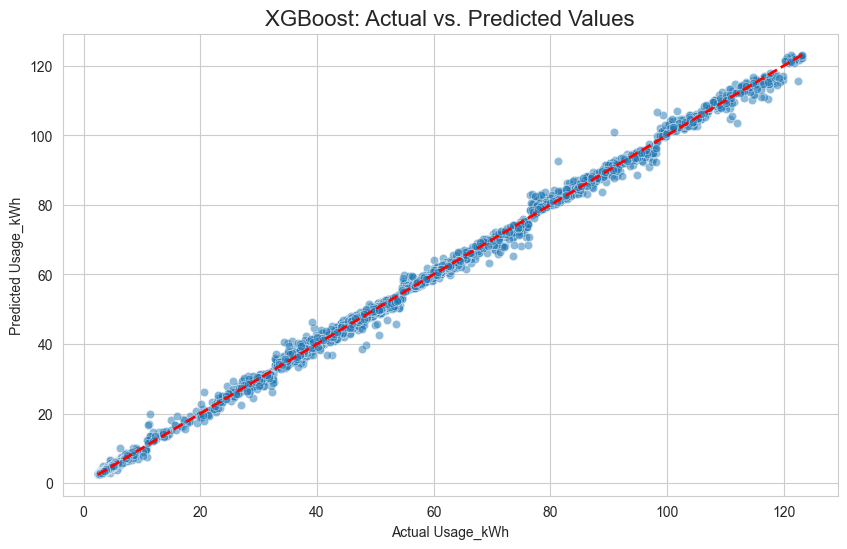

In [12]:
# --- Visualize Predictions ---
# A scatter plot of Actual vs. Predicted values.
# A perfect model would have all points on the 45-degree red line.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('XGBoost: Actual vs. Predicted Values', fontsize=16)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.show()


In [13]:
# --- Save the trained model ---
# This .pkl file will be loaded by your Streamlit dashboard
model_filename = 'xgb_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(xgb_reg, f)
    
print(f"\nModel saved successfully as '{model_filename}'")


Model saved successfully as 'xgb_model.pkl'


<Figure size 1200x800 with 0 Axes>

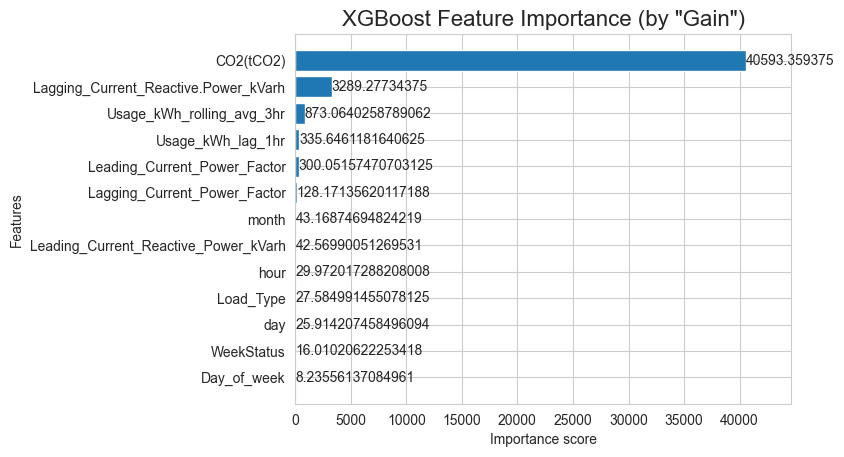

In [14]:
# --- Block 8: Feature Importance ---

# This shows which features the model found most predictive

plt.figure(figsize=(12, 8))
# Use the built-in XGBoost plot_importance
# 'gain' is a good metric, it shows the relative contribution
xgb.plot_importance(xgb_reg, max_num_features=20, height=0.8, importance_type='gain')
plt.title('XGBoost Feature Importance (by "Gain")', fontsize=16)
plt.show()